<a href="https://colab.research.google.com/github/lizmosquera/InteligenciaComputacional/blob/master/CNNandLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf_nightly-2.0-preview

ERROR: Could not find a version that satisfies the requirement tf_nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf_nightly-2.0-preview


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print (tf.__version__)

2.2.0-rc3


In [0]:
def plot_series(time,series,format="-",start=0,end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend (time,slope=0):
  return slope*time

def seasonal_pattern(season_time):
  """Just an arbitrary pattern, you can change it if you wish"""
  return np.where(season_time <0.4,np.cos(season_time*2*np.pi),1/np.exp(3*season_time))

def seasonality (time, period, amplitude=1,phase=0):
  """Repeats the same pattern at each period"""
  season_time=((time+phase)%period)/period
  return amplitude*seasonal_pattern(season_time)

def noise(time,noise_level=1,seed=None):
  rnd=np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

time=np.arange(4*365+1,dtype="float32")
baseline=10
series=trend(time,0.1)
baseline=10
amplitude=40
slope=0.05
noise_level=5

#ceate the series
series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
#update with noise
series +=noise(time,noise_level,seed=42)

split_time=1000
time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_valid=series[split_time:]

#linnear regresion
window_size=20
batch_size=32
shuffle_buffer_size=1000


In [0]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer): #crear un dataset
  series=tf.expand_dims(series, axis=-1) #create a dataset

  ds=tf.data.Dataset.from_tensor_slices(series)
  ds=ds.window(window_size+1,shift=1,drop_remainder=True)#to slice the data up into the appropriate windows
  ds=ds.flat_map(lambda w: w.batch(window_size+1))#flatten the data out flatened into chunksin the suze of our window_size+1
  ds=ds.shuffle(shuffle_buffer)
  ds=ds.map(lambda w:(w[:-1],w[-1])) #shuflet it, choosing smaller number speeds
 
  return ds.batch(batch_size).prefetch(1)#size parameter =2 corresponde Yb

In [0]:
def model_forecast(model,series,window_size):
  ds=tf.data.Dataset.from_tensor_slices(series)
  ds=ds.window(window_size,shift=1,drop_remainder=True)
  ds=ds.flat_map(lambda w: w.batch(window_size))
  ds=ds.batch(32).prefetch(1)
  forecast=model.predict(ds)
  return forecast

In [15]:
tf.keras.backend.clear_session() #limpia variable internas
tf.random.set_seed(51)
np.random.seed(51)

window_size=30
#tf.keras.backend.clear_session() 
train_set=windowed_dataset(x_train,window_size,batch_size=128,
                           shuffle_buffer=shuffle_buffer_size)

model=tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32,kernel_size=5,
                         strides=1, padding="causal",
                         activation="relu",
                         input_shape=[None,1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)), #capa single LSTM de 32 celdas
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
  tf.keras.layers.Dense(1), #neurona de salida
  tf.keras.layers.Lambda(lambda x:x*200.0)
])

lr_schedule=tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20))

optimizer=tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history=model.fit(train_set,epochs=100,callbacks=[lr_schedule])#500)#

Epoch 1/100
8/8 [==============================] - 1s 82ms/step - loss: 73.5305 - mae: 74.1154 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 1s 77ms/step - loss: 72.7323 - mae: 73.3982 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 1s 74ms/step - loss: 71.6987 - mae: 72.2500 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 1s 70ms/step - loss: 70.2610 - mae: 70.8111 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 1s 69ms/step - loss: 68.5874 - mae: 69.1363 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 1s 70ms/step - loss: 66.7149 - mae: 67.1954 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 1s 69ms/step - loss: 64.3503 - mae: 65.0137 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 1s 66ms/step - loss: 61.8950 - mae: 62.5179 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 1s 66ms/step - loss: 59.1666 - mae: 59.6764 - lr: 2.5

(1e-08, 0.0001, 0.0, 30.0)

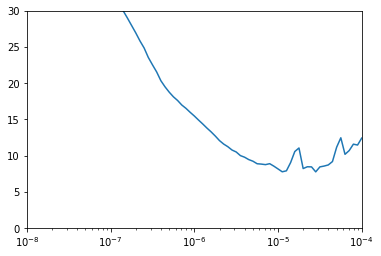

In [17]:
plt.semilogx(history.history["lr"],history.history["loss"])
plt.axis([1e-8,1e-4,0,30])

In [19]:
tf.keras.backend.clear_session() #limpia variable internas
tf.random.set_seed(51)
np.random.seed(51)
#batch_size=16
#window_size=30
#tf.keras.backend.clear_session() 

dataset=windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

model=tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32,kernel_size=3,
                         strides=1, padding="causal",
                         activation="relu",
                         input_shape=[None,1]),
  tf.keras.layers.LSTM(32,return_sequences=True),#capa single LSTM de 32 celdas
  tf.keras.layers.LSTM(32,return_sequences=True),
  tf.keras.layers.Dense(1), #neurona de salida
  tf.keras.layers.Lambda(lambda x:x*200.0)
])

#lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8*10**(epoch/20))

optimizer=tf.keras.optimizers.SGD(lr=1e-5,momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history=model.fit(dataset,epochs=500)#100,callbacks=[lr_schedule])

Epoch 1/500
31/31 [==============================] - 1s 26ms/step - loss: 21.8899 - mae: 22.4622
Epoch 2/500
31/31 [==============================] - 1s 27ms/step - loss: 10.8599 - mae: 11.4248
Epoch 3/500
31/31 [==============================] - 1s 27ms/step - loss: 10.0719 - mae: 10.5686
Epoch 4/500
31/31 [==============================] - 1s 28ms/step - loss: 9.4805 - mae: 9.9832
Epoch 5/500
31/31 [==============================] - 1s 28ms/step - loss: 9.2200 - mae: 9.7218
Epoch 6/500
31/31 [==============================] - 1s 28ms/step - loss: 8.9868 - mae: 9.5012
Epoch 7/500
31/31 [==============================] - 1s 27ms/step - loss: 8.8661 - mae: 9.4001
Epoch 8/500
31/31 [==============================] - 1s 28ms/step - loss: 9.0691 - mae: 9.6404
Epoch 9/500
31/31 [==============================] - 1s 28ms/step - loss: 8.8675 - mae: 9.2887
Epoch 10/500
31/31 [==============================] - 1s 28ms/step - loss: 8.5606 - mae: 9.0440
Epoch 11/500
31/31 [=======================

In [0]:
rnn_forecast=model_forecast(model,series[...,np.newaxis],window_size)
rnn_forecast=rnn_forecast[split_time-window_size:-1,-1,0]

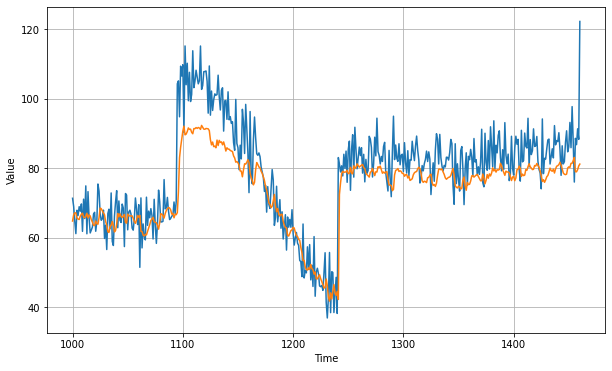

In [22]:
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,rnn_forecast)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid,rnn_forecast).numpy()

6.495191

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Legend does not support 'M' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Legend does not support 'A' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Legend does not support 'E' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Legend 

<Figure size 432x288 with 0 Axes>

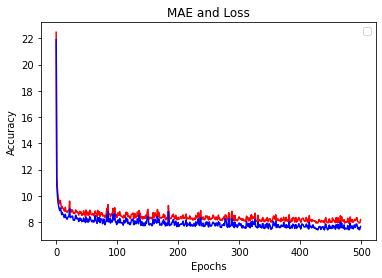

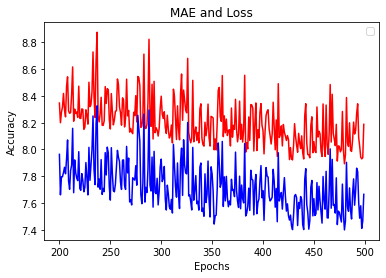

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# retrieve alist of list result on training and test data sets for each training epoch
mae=history.history["mae"]
loss=history.history["loss"]

epochs=range(len(loss))#get number of epochs

#plot MAE and Loss

plt.plot(epochs,mae,'r')
plt.plot(epochs,loss,'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend("MAE","Loss")

plt.figure()

epochs_zoom=epochs[200:]
mae_zoom=mae[200:]
loss_zoom=loss[200:]

#plot Zoomed MAE and Loss

plt.plot(epochs_zoom,mae_zoom,'r')
plt.plot(epochs_zoom,loss_zoom,'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend("MAE","Loss")

plt.figure()